# Практическая работа 1. Метод K-ближайших соседей

 **Задача: "Идентификация растений по фотографии с использованием радиусного
классификатора ближайших соседей"**

Описание задачи: Решить задачу идентификации растений по фотографиям с использованием радиусного классификатора ближайших соседей. Для этого можно воспользоваться набором данных, содержащим изображения различных видов растений.

https://www.kaggle.com/datasets/alxmamaev/flowers-recognition

Фотографии разделены на пять классов: ромашки, тюльпаны, розы, подсолнухи, одуванчики.
Для каждого класса представлено около 800 фотографий. Фотографии не имеют высокого разрешения, примерно 320x240 пикселей. Фотографии не сводятся к одному размеру, они имеют разные пропорции!

Мои этапы выполнения задачи:

Для выполнения поставленной задачи нам необходимо:

1. Определить тип задачи. У нас мультиклассовая классификация. т.к 5 классов

2. Фотографии можно не преобразовывать к 1 размеру т.к VGG16 приводит и масштабирует фотографии самостоятельно

3. Получить вектора признаков и labels

4. Обучить радиусный классификатор и провести оценку модели.

5. Применить алгоритм KNN и сравнить с радиусным классификатором

6. Сделать выводы

# Импортируем все изображения с kaggle

In [1]:
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip flowers-recognition.zip

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
 99% 222M/225M [00:03<00:00, 58.9MB/s]
100% 225M/225M [00:03<00:00, 68.4MB/s]
Archive:  flowers-recognition.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  


# Визуализация и анализ данных

Количество изображений в каждом классе:
sunflower: 733
tulip: 984
daisy: 764
dandelion: 1052
rose: 784


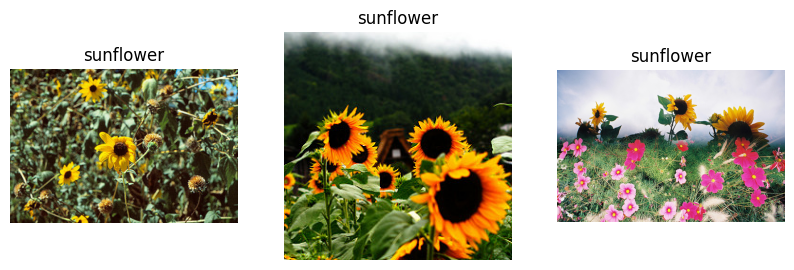

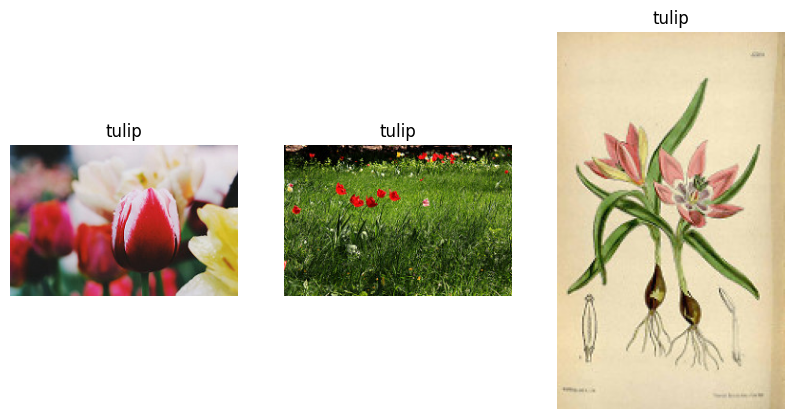

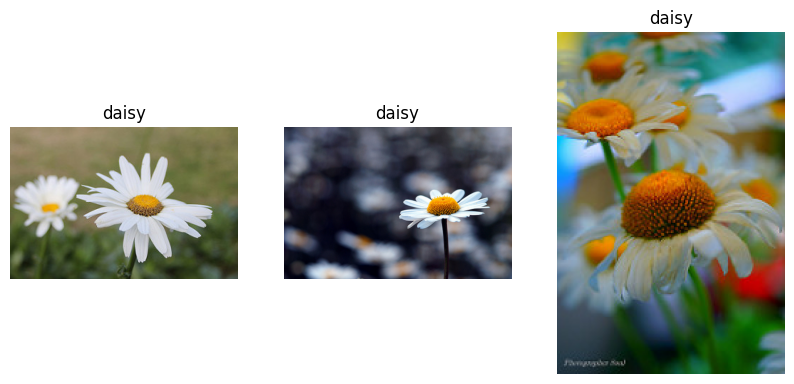

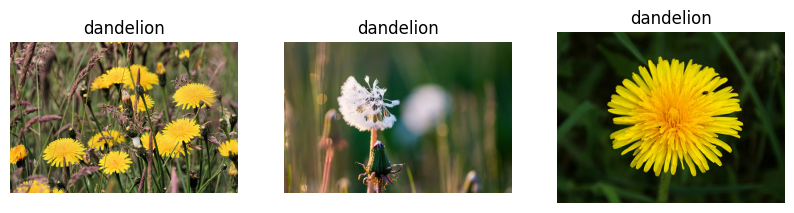

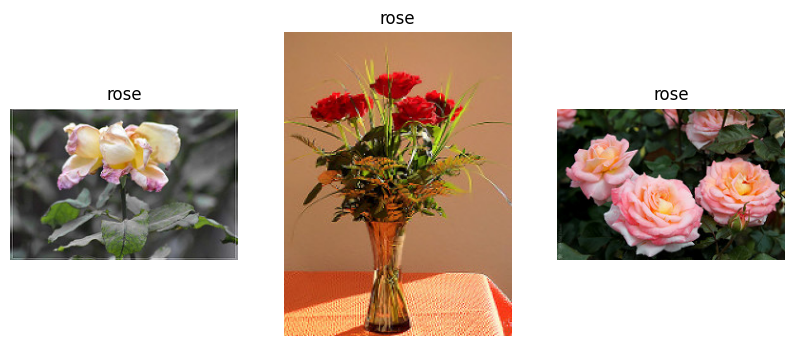

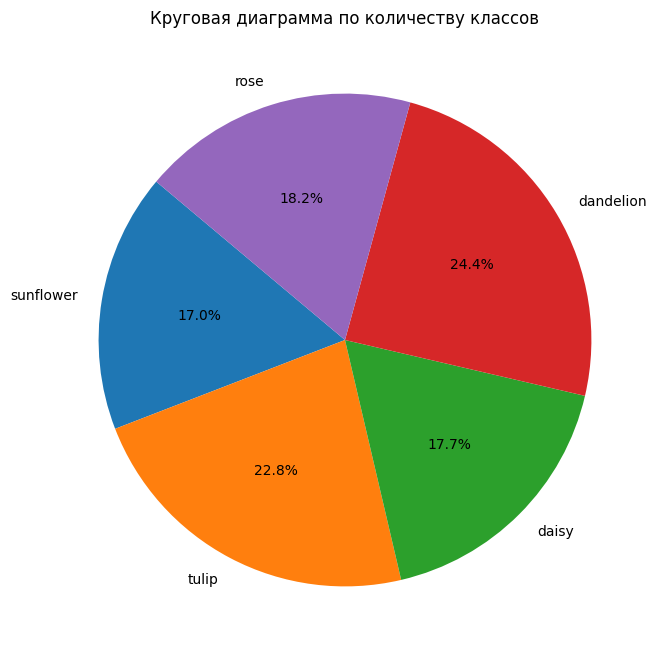

In [2]:
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

# Путь к папке с данными
data_dir = 'flowers'

# Получение списка классов
classes = os.listdir(data_dir)

# Подсчет количества изображений в каждом классе
class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

# Вывод количества изображений в каждом классе
print("Количество изображений в каждом классе:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

# Функция для отображения изображений
def display_images(class_name, num_images=3):
    class_path = os.path.join(data_dir, class_name)
    images = os.listdir(class_path)[:num_images]
    plt.figure(figsize=(10, 5))
    for i, image_name in enumerate(images):
        image_path = os.path.join(class_path, image_name)
        img = Image.open(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)
    plt.show()

# Вывод изображений из каждого класса
for cls in classes:
    display_images(cls)

# Построение круговой диаграммы по количеству классов
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Круговая диаграмма по количеству классов')
plt.show()

Данные заполнены +- равномерно. Аугментацию применим если точность будет низкая.

Сюрпризы в виде переобучения мы встретить не должны на тесте, т.к все данные заполнены равномерно.

Извлечение признаков

In [3]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model

в моделе VGG16 убраны полносвязные нейроны. Остались только сверточные слои

In [4]:
# Путь к папке с данными
data_dir = 'flowers'

# Получение списка классов
classes = os.listdir(data_dir)

# Загрузка предобученной модели VGG16 без верхних слоев
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

# Функция для извлечения признаков из изображения
def extract_features(image_path):
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features

# Извлечение признаков для всех изображений
features = []
labels = []

for cls in classes:
    class_path = os.path.join(data_dir, cls)
    images = os.listdir(class_path)
    for image_name in images:
        image_path = os.path.join(class_path, image_name)
        feat = extract_features(image_path)
        features.append(feat)
        labels.append(cls)

# Преобразование списков в массивы numpy
features = np.vstack(features)
labels = np.array(labels)

# Сохранение признаков и меток в файлы
np.save('features.npy', features)
np.save('labels.npy', labels)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━

Подготовка данных и разделение на train, test

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

X = features.reshape((features.shape[0], -1))
scaler = StandardScaler()
scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)

In [6]:
X_train.shape

(3453, 25088)

Используем энкодер для облегчения визуализации

In [7]:
import pandas as pd

encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_test = encode.fit_transform(y_test)

In [8]:
y_train

array([1, 4, 2, ..., 1, 0, 0])

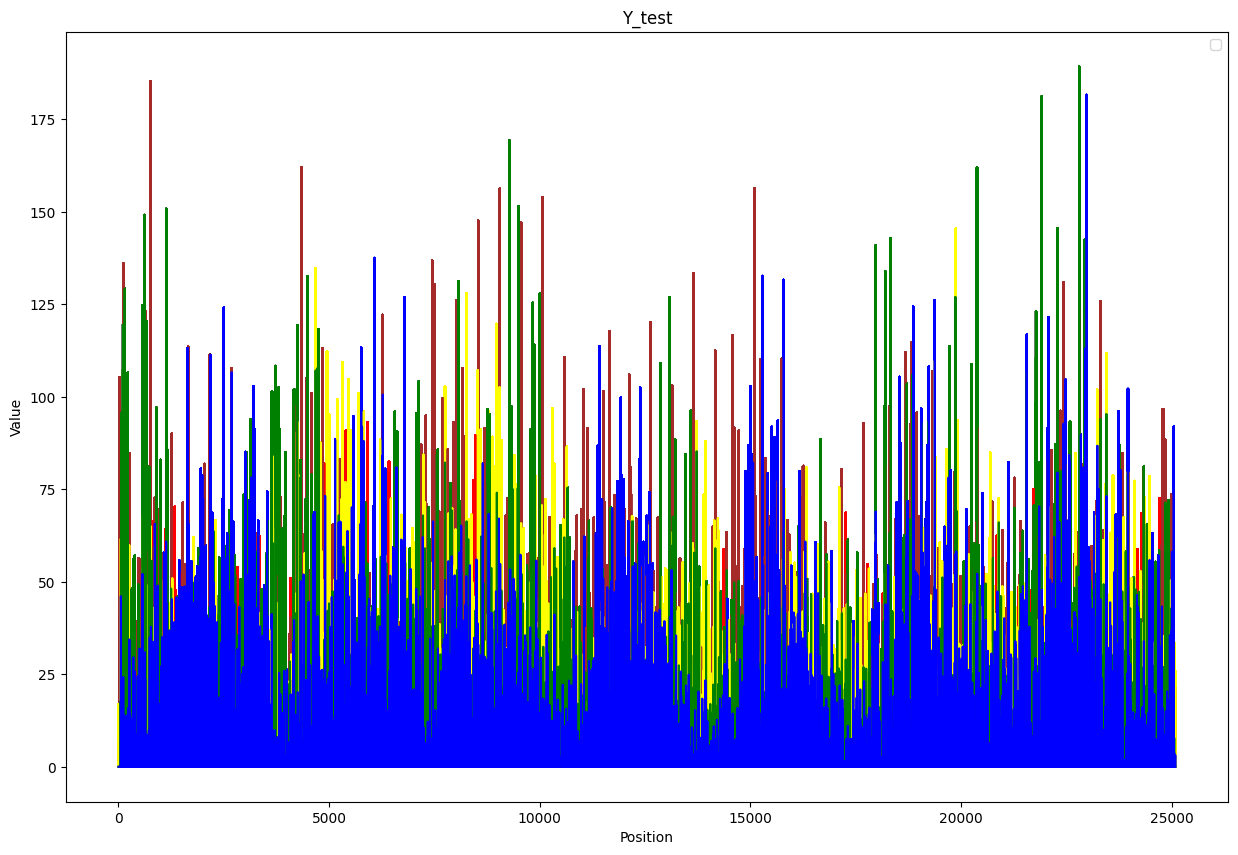

In [9]:
import matplotlib.pyplot as plt

colors = ['blue', 'red', 'yellow', 'green', 'brown']

plt.figure(figsize=(15, 10))

for class_label in y_test:

  plt.plot(X_test[class_label], color=colors[class_label])

plt.title('Y_test')
plt.xlabel('Position')
plt.ylabel('Value')
plt.legend()
plt.show()

Радиусный классификатор

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors=5)
knc.fit(X_train, y_train)
pred = knc.predict(X_test)

In [11]:
pred[:10]

array([2, 1, 0, 0, 4, 0, 1, 0, 1, 0])

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, pred)
print(f'Accuracy: {accuracy}')

precision = precision_score(y_test, pred, average='weighted')
print(f'Precision: {precision}')

recall = recall_score(y_test, pred, average='weighted')
print(f'Recall: {recall}')

f1 = f1_score(y_test, pred, average='weighted')
print(f'F1-score: {f1}')

Accuracy: 0.5671296296296297
Precision: 0.7076042167223093
Recall: 0.5671296296296297
F1-score: 0.5503981072154974


Параметр cv в GridSearchCV означает "cross-validation" (кросс-валидация).

 cv=5 - использована 5-кратная кросс-валидация.

Кросс-валидация — это метод оценки модели, при котором данные разбиваются на несколько подмножеств (fold). В случае 5-кратной кросс-валидации данные разбиваются на 5 частей. Модель обучается на 4 частях и тестируется на оставшейся части. Этот процесс повторяется 5 раз, каждый раз с другой частью данных в качестве тестового набора. В результате получается 5 оценок модели, которые затем усредняются для получения окончательной оценки.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [1, 2, 3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

best_model = grid_search.best_estimator_
pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Best Parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
Best Score: 0.5823830197780995
Accuracy: 0.6203703703703703
Precision: 0.6871829553755219
Recall: 0.6203703703703703
F1-score: 0.6128702114270572


[]

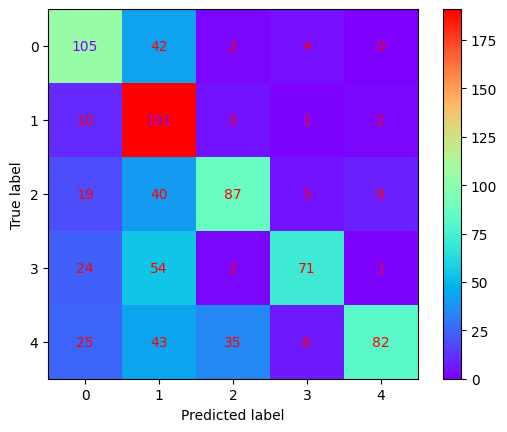

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=best_model.classes_)
disp.plot(cmap = 'rainbow')
plt.plot()

In [24]:
from collections import Counter

Counter(y_test)

Counter({2: 159, 3: 152, 0: 153, 4: 191, 1: 209})

Сравниваем с K-means и подводим итоги

In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
kmeans.fit(X_train)

pred = kmeans.predict(X_test)


accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Accuracy: 0.35300925925925924
Precision: 0.4038830990928303
Recall: 0.35300925925925924
F1-score: 0.34902262110894894


[]

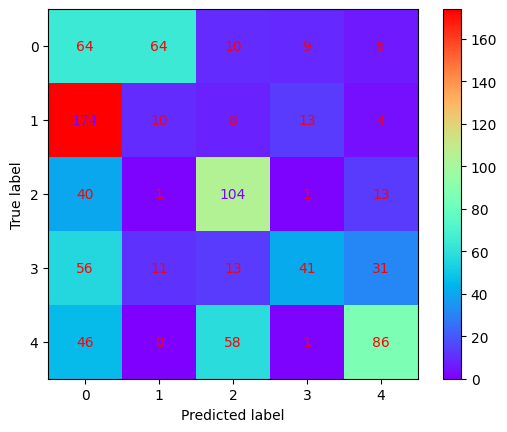

In [26]:
cm = confusion_matrix(y_test, pred)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=best_model.classes_)
disp.plot(cmap = 'rainbow')
plt.plot()

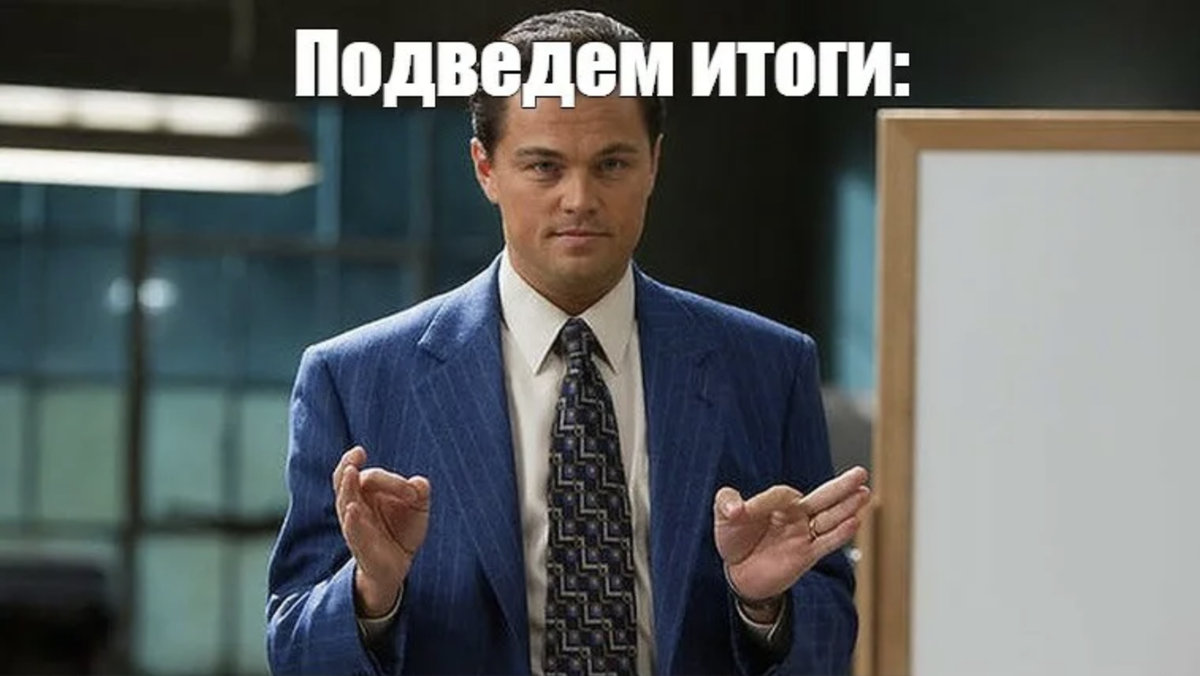

**Kmeans**

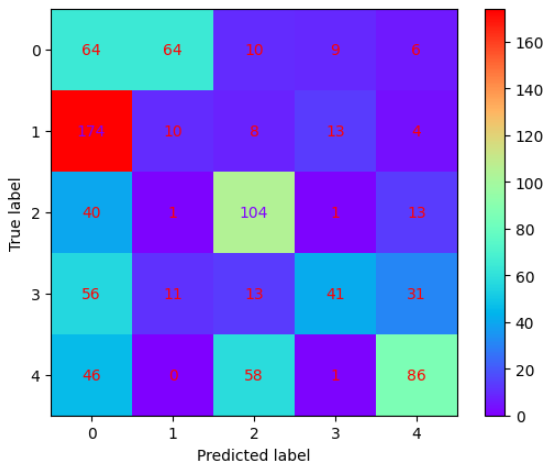

**KNC**

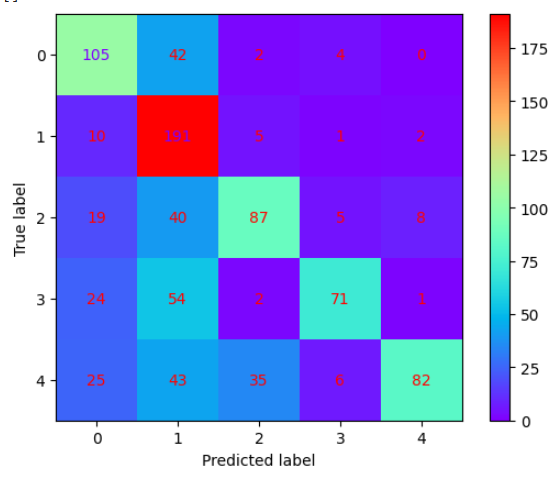

KNC получился более гибким и точным. Он может изменять количество соседей, для нахождения оптимальных параметров, kmean показал себя хуже